In [66]:
#https://analyticsindiamag.com/lasso-regression-in-python-with-machinehack-data-science-hackathon/
from sklearn.linear_model import Lasso
from sklearn import metrics
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict
import heapq

class Alpha_Finder:
    def __init__(self):
        self.all_transformed_data = pd.read_csv("./transformed_samples_by_features.csv").drop(columns=["Unnamed: 0"]).values
        self.all_feature_names = pd.read_csv("./transformed_samples_by_features.csv").drop(columns=["Unnamed: 0"]).columns
        self.youngs_data = pd.read_csv("./Oxide_glass_1_5_02142020.csv")["Young's modulus E (GPa)"].values
        self.shear_data = pd.read_csv("./Oxide_glass_1_5_02142020.csv")["Shear modulus G (GPa)"].values
        self.poissons_data = pd.read_csv("./Oxide_glass_1_5_02142020.csv")["Poisson's ratio v"].values
        self.alpha_powers = [0, 1, 1.5, 2, 2.5]
        self.alpha_vals = []
        for i in range(len(self.alpha_powers)):
            self.alpha_vals.append(10**(-self.alpha_powers[i]))
        self.states = [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71]
    
    def calculate_alpha_rmse(self, y_data): #CHOOSE FROM "YOUNGS", "SHEAR", "POISSONS"
        if y_data == "YOUNGS":
            y_data = self.youngs_data
        elif y_data == "SHEAR":
            y_data = self.shear_data
        elif y_data == "POISSONS":
            y_data = self.poissons_data
        alpha_state_to_rmse_test = {}
        alpha_state_to_rmse_train = {}

        for alpha_val in self.alpha_vals:
            for state in self.states:
                X_train, X_test, y_train, y_test = train_test_split(self.all_transformed_data, y_data, test_size=0.2, random_state=state)
                lasso = Lasso(alpha = alpha_val, max_iter = 150000)
                lasso.fit(X_train, y_train)

                y_pred_test = lasso.predict(X_test)
                y_pred_train = lasso.predict(X_train)
                alpha_state_to_rmse_test[(alpha_val, state)] = math.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
                alpha_state_to_rmse_train[(alpha_val, state)] = math.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
        return alpha_state_to_rmse_train, alpha_state_to_rmse_test
    
    def average_rmse(self, train, test):
        train_rmse = defaultdict(float) #alpha, sum RMSE
        for key in train.keys():
            train_rmse[key[0]] += train[key]

        test_rmse = defaultdict(float)
        for key in test.keys():
            test_rmse[key[0]] += test[key]

        train_rmse_averaged = []
        for key in train_rmse:
            train_rmse_averaged.append(train_rmse[key]/len(self.states))

        test_rmse_averaged = []
        for key in test_rmse:
            test_rmse_averaged.append(test_rmse[key]/len(self.states))
        return train_rmse_averaged, test_rmse_averaged
    def plot_rmse_alpha(self, train, test, name, color):
        plt.rcParams["figure.figsize"] = (5, 5)
        plt.plot(self.alpha_powers, train, color + "--", label = "Train for " + name)
        plt.plot(self.alpha_powers, test, color, label = "Test for " + name)
        plt.title("Averaged RMSE vs. -log(alpha) of Lasso for 15 Random States " + name)
        plt.ylabel("Averaged RMSE")
        plt.xlabel("-log(alpha)")
        plt.legend()
        
    def lasso_coeffs(self, alpha_val, column, name):
        lasso = Lasso(alpha = alpha_val)

        X = self.all_transformed_data
        Y = pd.read_csv("./Oxide_glass_1_5_02142020.csv")[column].values
        plt.rcParams["figure.figsize"] = (80,15)
        lasso_coeff = lasso.fit(X, Y).coef_
        plotting = plt.plot(range(len(self.all_feature_names)), lasso_coeff)
        plotting = plt.xticks(range(len(self.all_feature_names)), self.all_feature_names, rotation=60)
        plotting = plt.ylabel("Coefficients")
        plotting = plt.title("Coefficients for " + name)
        plt.show() #Do cross-validation
    
        return lasso_coeff
    
    def coeffs_to_dict(self, coeffs):
        feature_names_to_coeff = {}
        for i in range(len(self.all_feature_names)):
            feature_names_to_coeff[self.all_feature_names[i]] = coeffs[i]
        return feature_names_to_coeff
    
    def filter_coeff_dicts(self, d):
        filtered_names_to_coeff = {}
        for feature in d:
            if d[feature] != 0.0 and d[feature] != -0.0:
                filtered_names_to_coeff[feature] = abs(d[feature])
        return filtered_names_to_coeff
    
    def rank_coeffs(self, filtered):
        ranked_names = []
        for name in filtered:
            ranked_names.append((name, filtered[name]))
        ranked_names.sort(key = lambda x: x[1], reverse = True)
        return ranked_names
    
    def select_features(self, names):
        selected_features = [name for name, val in names]
        return selected_features

alpha_obj = Alpha_Finder()

In [11]:
youngs_train, youngs_test = alpha_obj.calculate_alpha_rmse("YOUNGS")
shear_train, shear_test = alpha_obj.calculate_alpha_rmse("SHEAR")
poisson_train, poisson_test = alpha_obj.calculate_alpha_rmse("POISSONS")

In [17]:
youngs_average_rmse_train, youngs_average_rmse_test = alpha_obj.average_rmse(youngs_train, youngs_test)
shear_average_rmse_train, shear_average_rmse_test = alpha_obj.average_rmse(shear_train, shear_test)
poisson_average_rmse_train, poisson_average_rmse_test = alpha_obj.average_rmse(poisson_train, poisson_test)

[18.2174724741269,
 11.676105169005474,
 10.418913254321266,
 9.5538465763194,
 9.08994155877228]

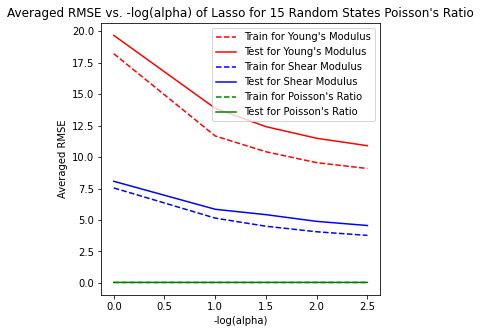

In [49]:
alpha_obj.plot_rmse_alpha(youngs_average_rmse_train, youngs_average_rmse_test, "Young's Modulus", "r")
alpha_obj.plot_rmse_alpha(shear_average_rmse_train, shear_average_rmse_test, "Shear Modulus", "b")
alpha_obj.plot_rmse_alpha(poisson_average_rmse_train, poisson_average_rmse_test, "Poisson's Ratio", "g")
#From here we know that the most optimal -log(alpha value would be 10^(-2))
#Finer search around "optimal -log(alpha value)"
#1.0

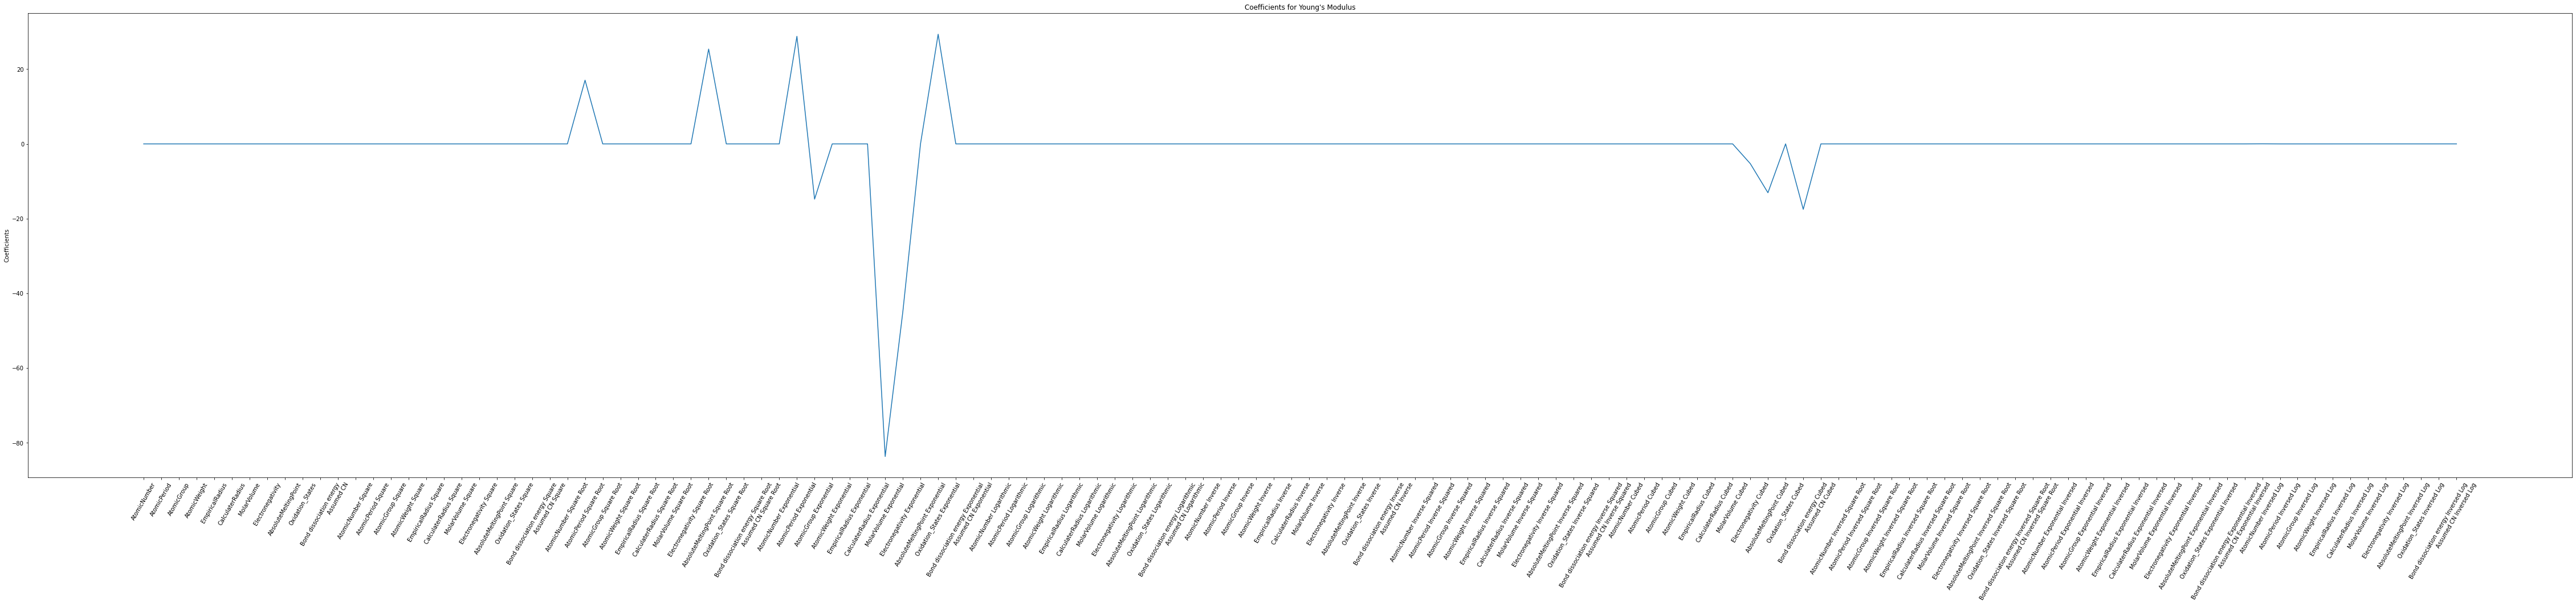

In [52]:
youngs_coeffs = alpha_obj.lasso_coeffs(10**(-1), "Young's modulus E (GPa)", "Young's Modulus")

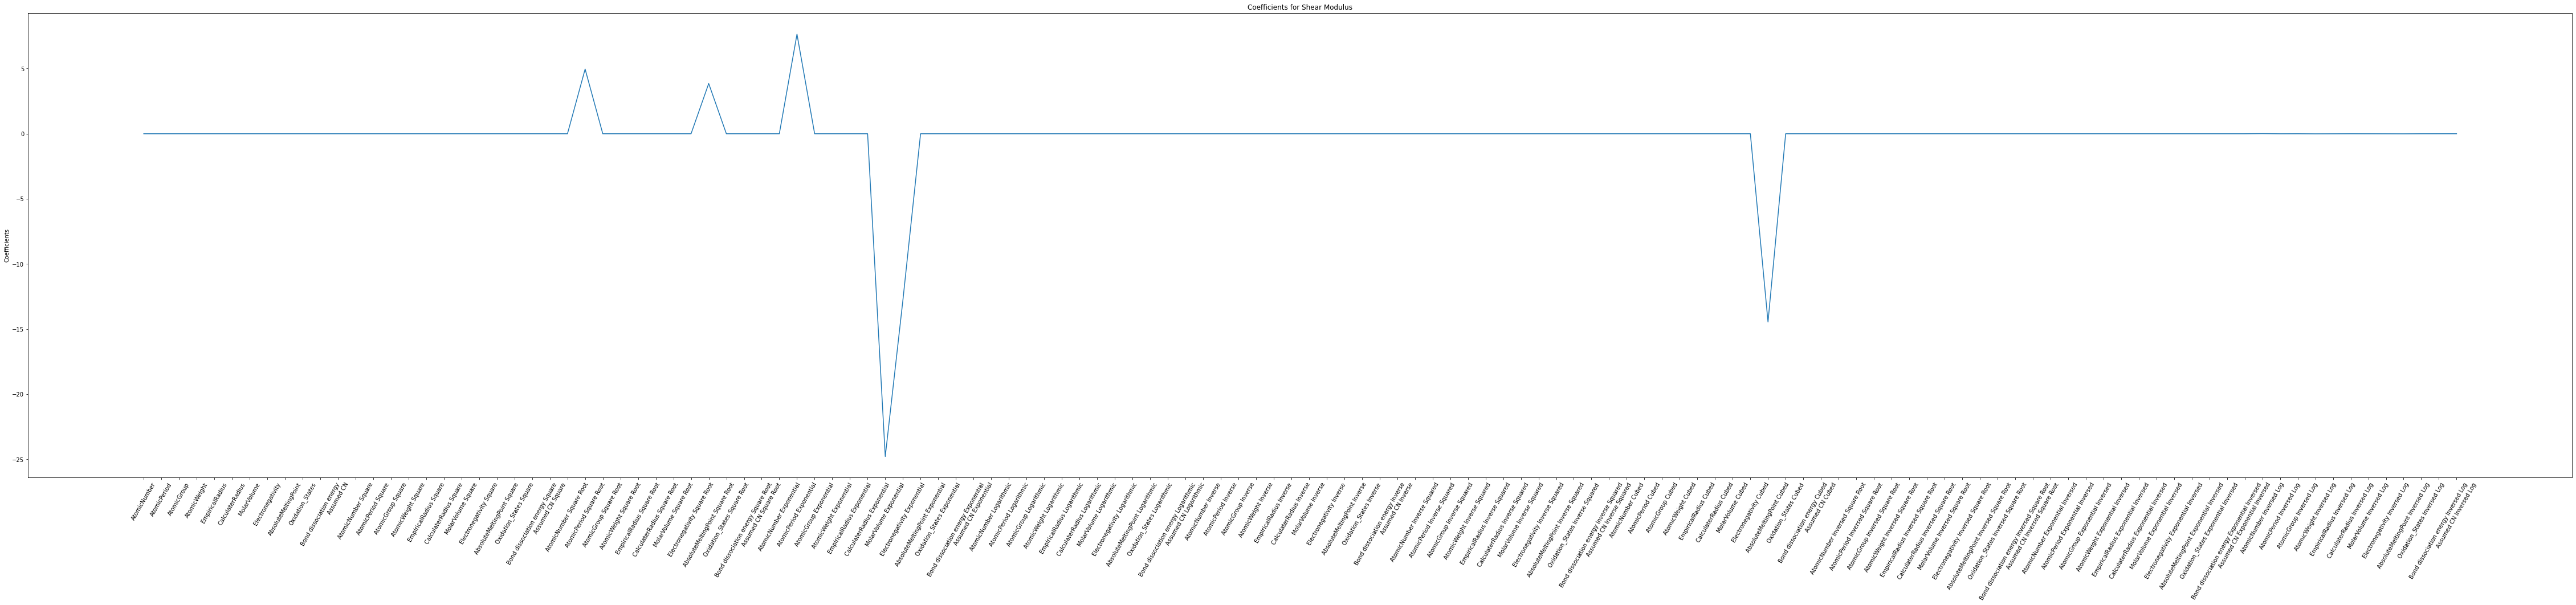

In [55]:
shear_coeffs = alpha_obj.lasso_coeffs(10**(-1), "Shear modulus G (GPa)", "Shear Modulus")

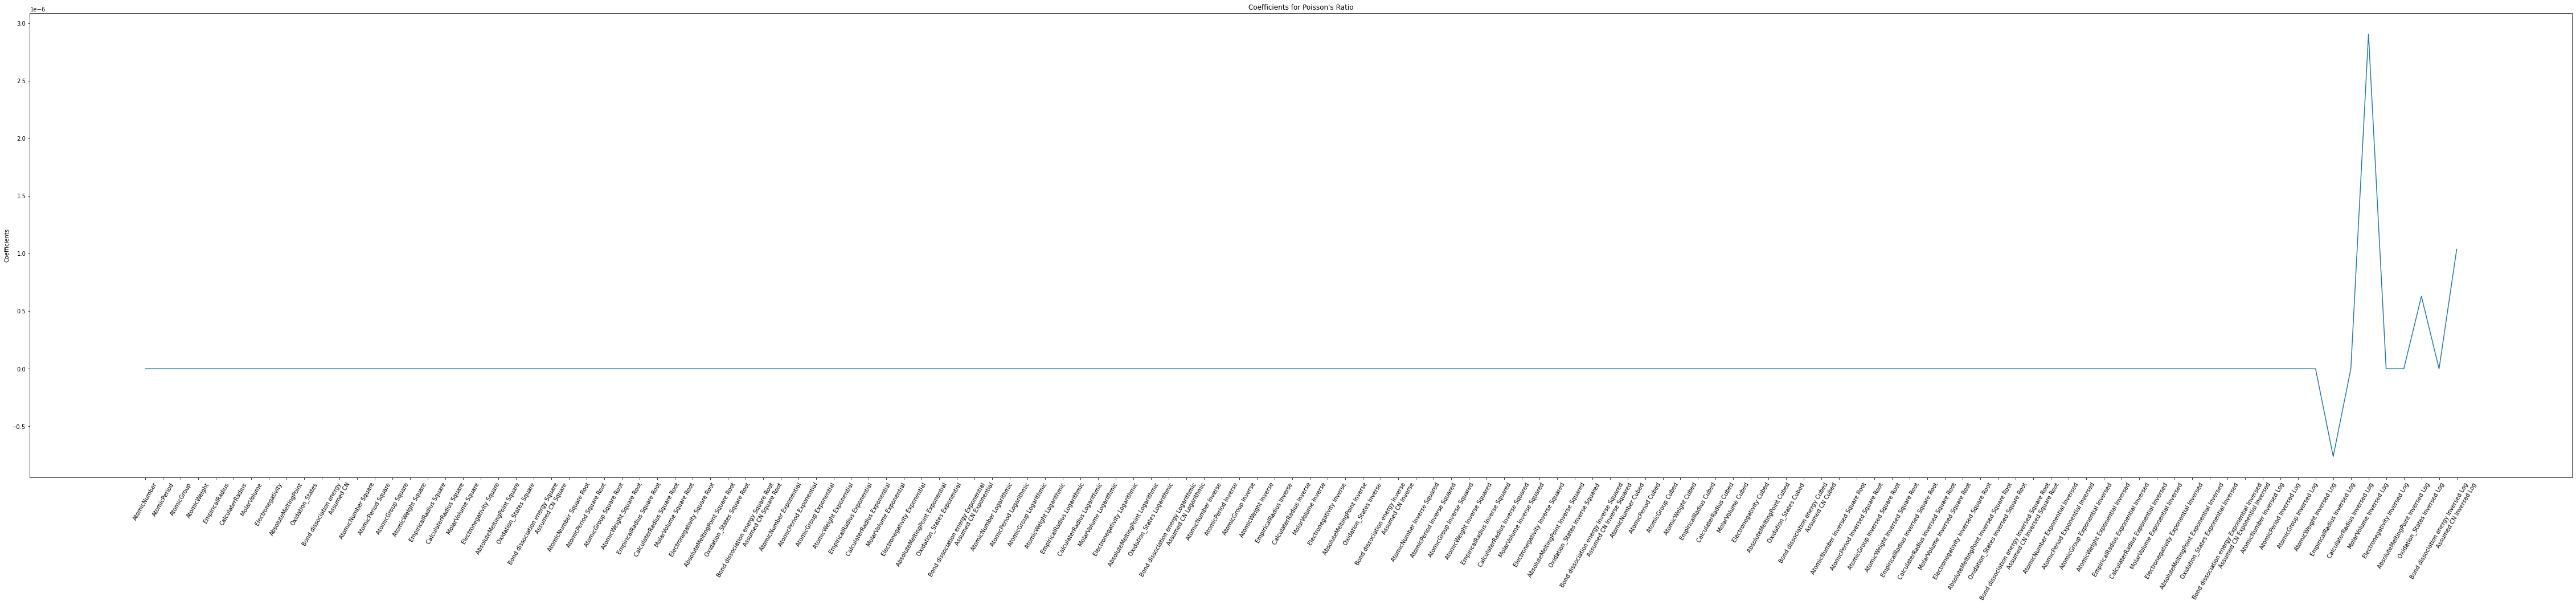

In [54]:
poisson_coeffs = alpha_obj.lasso_coeffs(10**(-1), "Poisson's ratio v", "Poisson's Ratio")

In [58]:
youngs_coeffs_dict = alpha_obj.coeffs_to_dict(youngs_coeffs)
shear_coeffs_dict = alpha_obj.coeffs_to_dict(shear_coeffs)
poisson_coeffs_dict = alpha_obj.coeffs_to_dict(poisson_coeffs)

In [62]:
youngs_coeffs_dict = alpha_obj.filter_coeff_dicts(youngs_coeffs_dict)
shear_coeffs_dict = alpha_obj.filter_coeff_dicts(shear_coeffs_dict)
poisson_coeffs_dict = alpha_obj.filter_coeff_dicts(poisson_coeffs_dict)

In [65]:
youngs_ranked = alpha_obj.rank_coeffs(youngs_coeffs_dict)
shear_ranked = alpha_obj.rank_coeffs(shear_coeffs_dict)
poisson_ranked = alpha_obj.rank_coeffs(poisson_coeffs_dict)

In [67]:
youngs_selected = alpha_obj.select_features(youngs_ranked)
shear_selected = alpha_obj.select_features(shear_ranked)
poisson_selected = alpha_obj.select_features(poisson_ranked)

In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

def rmse(score):
    rmse = np.sqrt(-score)
    print(f'rmse= {"{:.2f}".format(rmse)}')

estimators = [num for num in range(1, 50)]
def random_forest(selected, drop1, drop2, current):
    selected_data = pd.read_csv("./transformed_samples_by_features.csv").drop(columns=["Unnamed: 0"])
    selected_features_df = pd.DataFrame()
    for feature in selected:
        selected_features_df[feature] = selected_data[feature]
    selected_features_df

    pred = pd.read_csv("./Oxide_glass_1_5_02142020.csv").drop(["Index", "Code", "Glass #", "Author", "Year", "Trademark", "Glass_composition", drop1, drop2], axis = 1)
    X = selected_features_df.iloc[:, 0:len(selected)]
    Y = pred[current]#"Young's modulus E (GPa)"]

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=30)
    
    rmse_test = []
    rmse_train = []
    for i in estimators:
        regressor = RandomForestRegressor(n_estimators=i, random_state=0)
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        rmse_test.append(math.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    for i in estimators:
        regressor = RandomForestRegressor(n_estimators=i, random_state=0)
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_train)
        rmse_train.append(math.sqrt(metrics.mean_squared_error(y_train, y_pred)))
    return rmse_train, rmse_test
youngs_rmse_train, youngs_rmse_test = random_forest(youngs_selected, "Shear modulus G (GPa)", "Poisson's ratio v", "Young's modulus E (GPa)")
shear_rmse_train, shear_rmse_test = random_forest(shear_selected, "Young's modulus E (GPa)", "Poisson's ratio v", "Shear modulus G (GPa)")
poisson_rmse_train, poisson_rmse_test = random_forest(poisson_selected, "Young's modulus E (GPa)", "Shear modulus G (GPa)", "Poisson's ratio v")

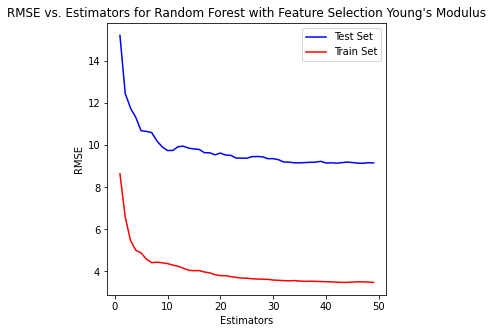

In [69]:
def plot_rmse_estimators(rmse_train, rmse_test, name):
    plt.rcParams["figure.figsize"] = (5, 5)
    plt.plot(estimators, rmse_test, "b", label = "Test Set")
    plt.plot(estimators, rmse_train, "r", label = "Train Set")
    plt.title("RMSE vs. Estimators for Random Forest with Feature Selection " + name)
    plt.xlabel("Estimators")
    plt.ylabel("RMSE")
    plt.legend()
plot_rmse_estimators(youngs_rmse_train, youngs_rmse_test, "Young's Modulus")


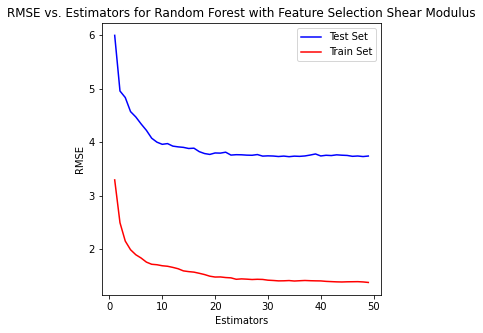

In [72]:
plot_rmse_estimators(shear_rmse_train, shear_rmse_test, "Shear Modulus")


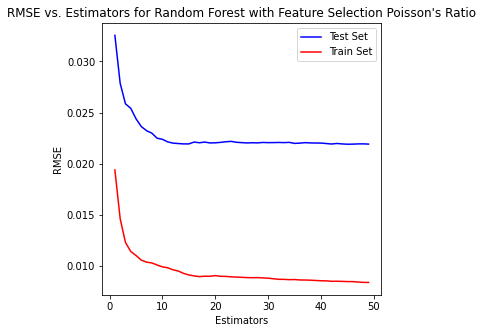

In [71]:
plot_rmse_estimators(poisson_rmse_train, poisson_rmse_test, "Poisson's Ratio")